## Initial Setup

In [0]:
%%capture
#%%script false
!pip install shap==0.23.0
!pip install xgboost==0.82
!pip install catboost
!pip install lightgbm==2.2.4
#!pip install tensorboardcolab
!pip install seaborn==0.9.0
!pip install pandas==0.24.2
!pip install numpy==1.16.2
!pip install scikit-optimize==0.6

#Restart Runtime

## Data

Train on whole data.  
Sklearn pipeline.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('figure', figsize=(20.0, 6.0))
import datetime as date

import shap
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
#from sklearn.model_selection import StratifiedShuffleSplit #, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

#import sklearn.svm as svm
#import sklearn.neighbors as knn


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.metrics import mean_squared_error #, mean_squared_log_error

In [0]:
train_data_og = pd.read_csv("https://drive.google.com/uc?export=download&id=1IvvyZeuJCKJuMF36EPc-kGqtfyv1FQo3", parse_dates = ["registration_date", "sold_date"], dayfirst = True)

Mielage has some negative values, zeros - are they NA's

### Manipulation

Mileage and Engine_Power NA's identified during EDA.

In [0]:

def clean_data(dataset) :
    
    op_set_1 = (dataset
                    .assign( Age = (date.datetime(2019, 12, 1) - dataset.registration_date).dt.days )
                    .assign( SoldAge = (dataset.sold_date - dataset.registration_date).dt.days )
                    .assign( YAge = 2019 - dataset.registration_date.dt.year )
                    .assign( RMonth = pd.Categorical(dataset.registration_date.dt.month) )
                    .assign( SMonth = pd.Categorical(dataset.sold_date.dt.month) )
                    .assign( mileage = np.where(dataset.mileage <= 0, np.nan, dataset.mileage) )
                    .assign( engine_power = np.where(dataset.engine_power <= 0, np.nan, dataset.engine_power) )
                
                    .drop(["car_company", "registration_date", "sold_date"], axis = 1)
                    
                    #.assign(SAge = 2019 - dataset.sold_date.dt.year)
               )

    
    return op_set_1

train_data = clean_data(train_data_og)
train_data.head()

,model_ID,mileage,engine_power,fuel,car_paint_color,car_type,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,car_price,Age,SoldAge,YAge,RMonth,SMonth
0,318 Gran Turismo,140245.0,105.0,diesel,white,hatchback,False,True,False,False,True,True,True,True,19200,1887,1247,5,10,3
1,218 Active Tourer,91512.0,100.0,petrol,white,van,False,True,True,False,False,False,True,False,14300,1644,1065,4,6,5
2,318,113744.0,100.0,diesel,grey,sedan,True,True,False,False,False,False,True,False,14300,2739,2191,7,6,6
3,320 Gran Turismo,195063.0,135.0,diesel,black,hatchback,False,True,True,False,True,False,True,True,16200,2040,1400,5,5,3
4,518,148943.0,100.0,diesel,brown,estate,True,True,True,False,True,False,True,True,17300,2221,1642,6,11,5


In [0]:
train_data.describe()

,mileage,engine_power,car_price,Age,SoldAge,YAge
count,3.389000e+03,3389.000000,3390.000000,3390.000000,3390.000000,3390.000000
mean,1.416525e+05,128.955149,15899.203540,2564.055752,1983.184071,6.531563
std,6.138493e+04,39.327670,9444.167874,919.234375,925.077536,2.517459
min,2.399000e+03,25.000000,100.000000,760.000000,273.000000,2.000000
25%,1.033300e+05,100.000000,10900.000000,2070.000000,1489.000000,5.000000
50%,1.417170e+05,120.000000,14200.000000,2344.000000,1767.000000,6.000000
75%,1.753100e+05,135.000000,18600.000000,2709.000000,2130.000000,7.000000
max,1.000376e+06,423.000000,178500.000000,10867.000000,10258.000000,29.000000


In [0]:
train_data.corr()[["car_price"]]

,car_price
mileage,-0.393228
engine_power,0.635380
feature1,0.265113
feature2,0.242695
feature3,0.245378
feature4,0.418791
feature5,0.252008
feature6,0.208656
feature7,0.000808
feature8,0.443792


## EDA

seaborn or pandas plot as required.  
verify labels truth - a new column called sample_weights may be helpful for noisy data.

### Distribution

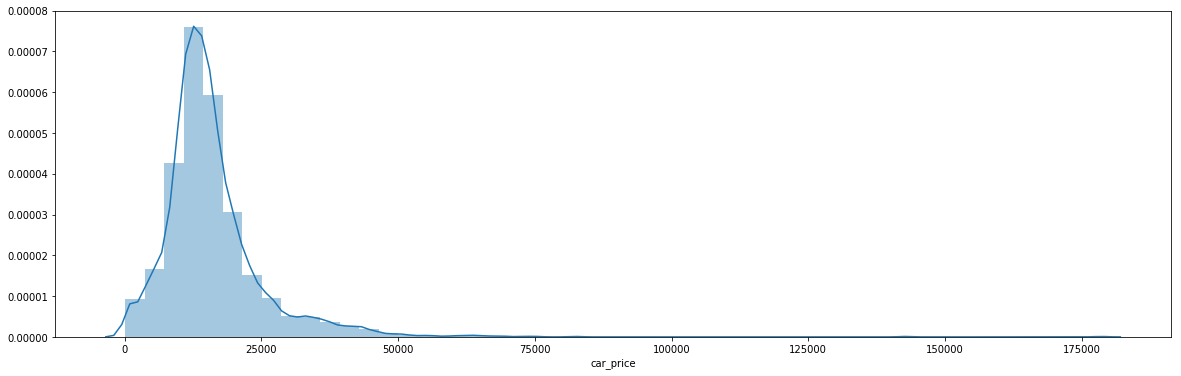

In [0]:
sns.distplot(train_data_og.car_price)
plt.show()

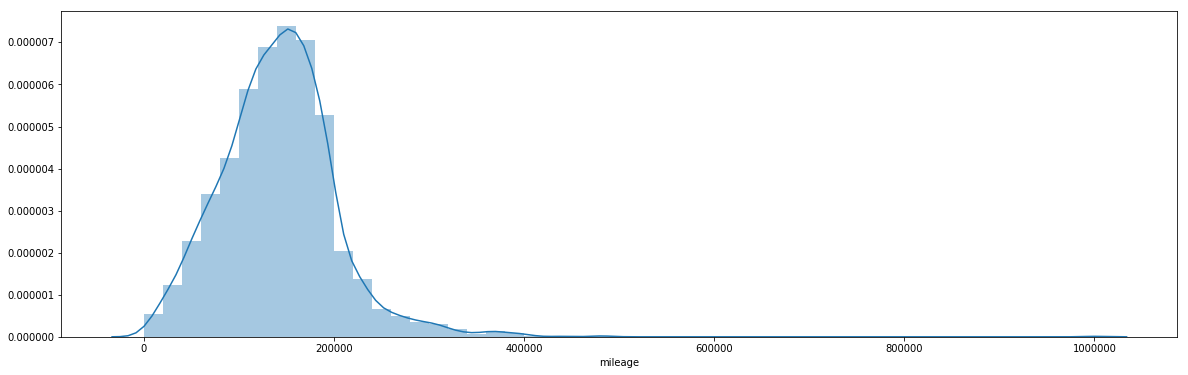

In [0]:
sns.distplot(train_data_og.mileage)
plt.show()
# Negative values?

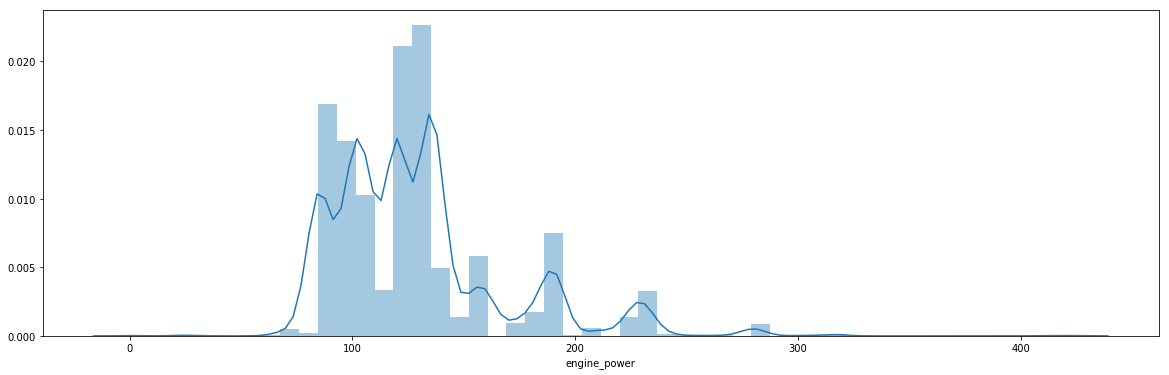

In [0]:
sns.distplot(train_data_og.engine_power)
plt.show()

# Have zero's are they NA?

### Univariate

Distributions, Outliers

In [0]:
sns.countplot(train_data_og.car_company, order = train_data_og.car_company.value_counts().index )
plt.show()

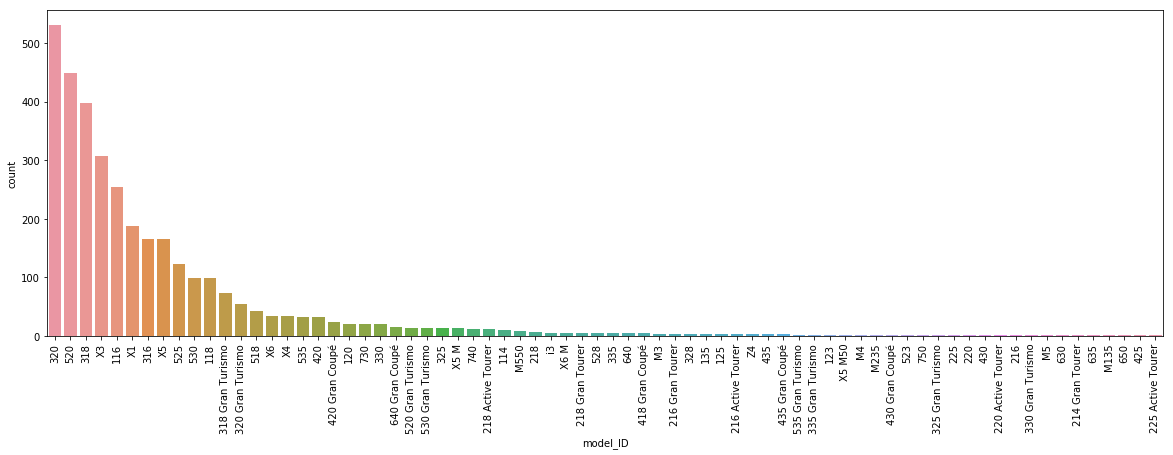

In [0]:
sns.countplot(train_data_og.model_ID, order = train_data_og.model_ID.value_counts().index )
plt.xticks(rotation = 90)
plt.show()

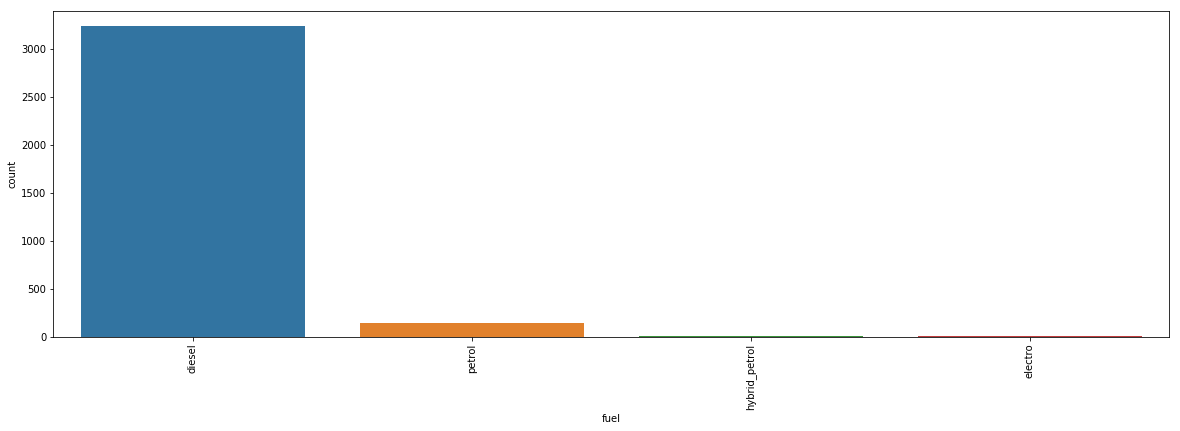

In [0]:
sns.countplot(train_data_og.fuel, order = train_data_og.fuel.value_counts().index )
plt.xticks(rotation = 90)
plt.show()

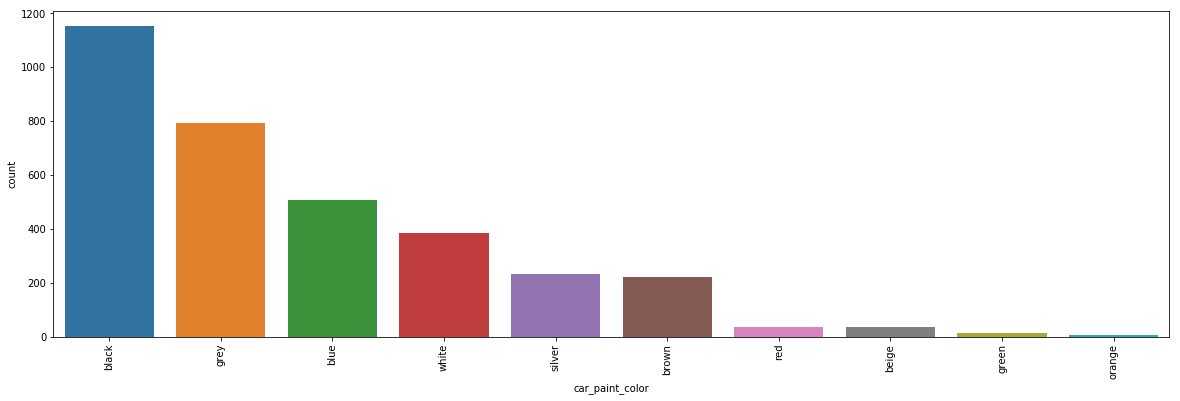

In [0]:
sns.countplot(train_data_og.car_paint_color, order = train_data_og.car_paint_color.value_counts().index )
plt.xticks(rotation = 90)
plt.show()

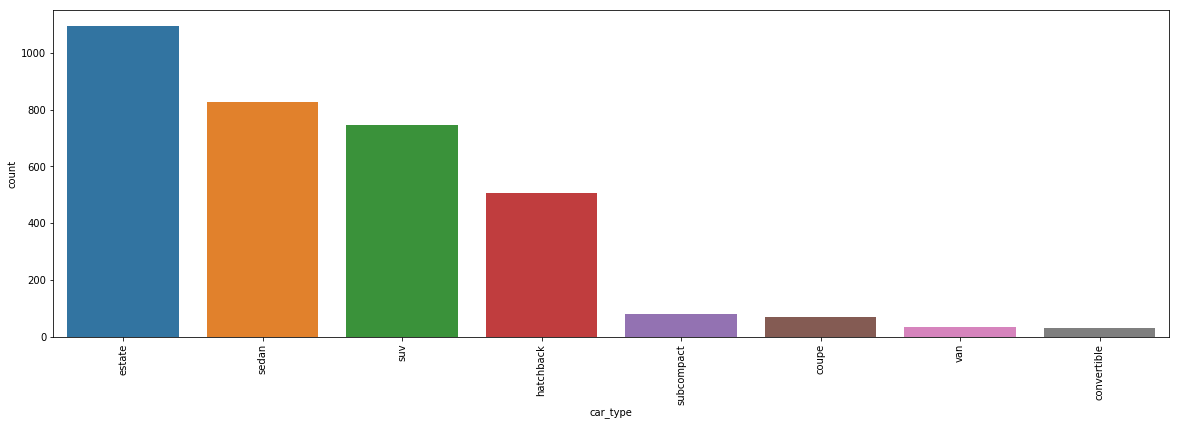

In [0]:
sns.countplot(train_data_og.car_type, order = train_data_og.car_type.value_counts().index )
plt.xticks(rotation = 90)
plt.show()

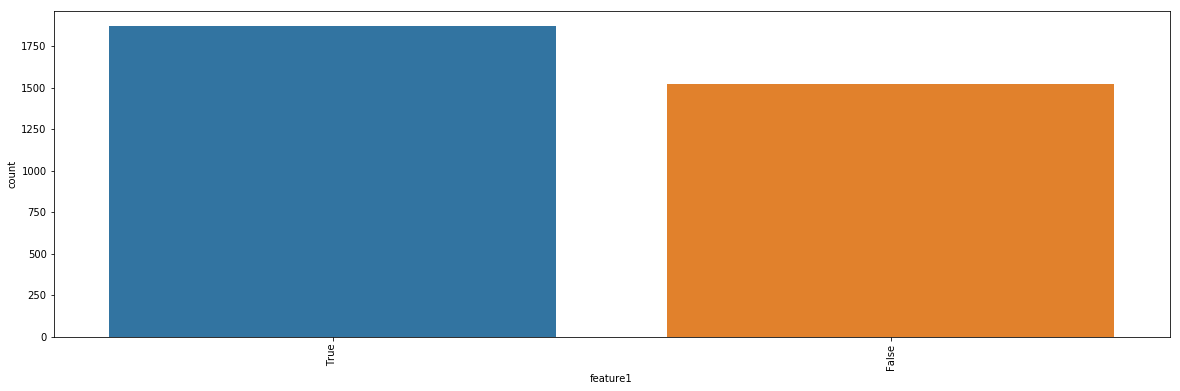

In [0]:
sns.countplot(train_data_og.feature1, order = train_data_og.feature1.value_counts().index )
plt.xticks(rotation = 90)
plt.show()

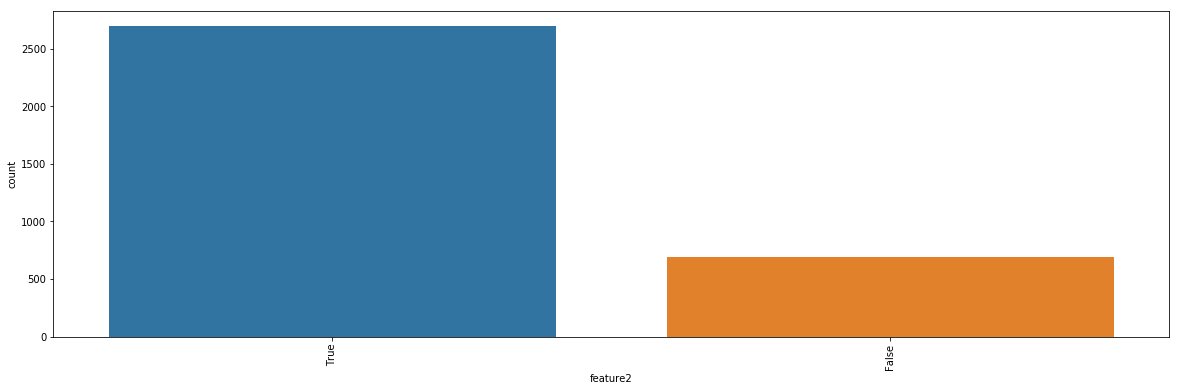

In [0]:
sns.countplot(train_data_og.feature2, order = train_data_og.feature2.value_counts().index )
plt.xticks(rotation = 90)
plt.show()

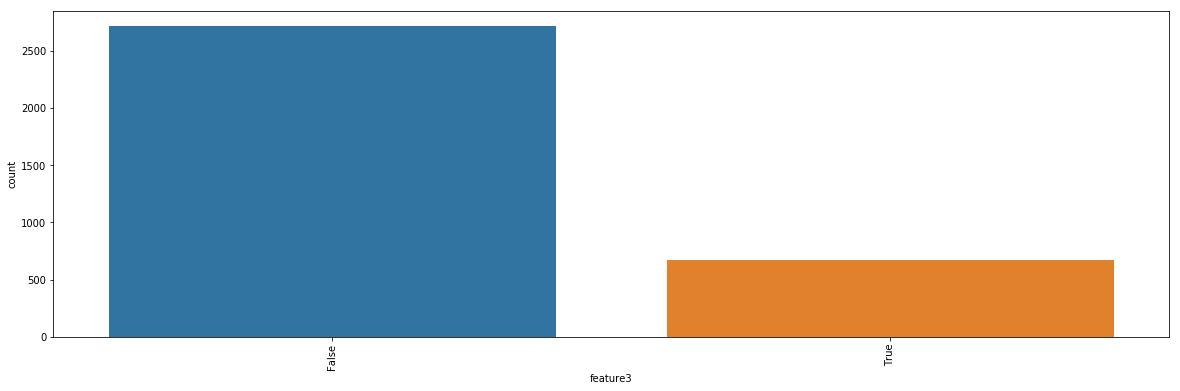

In [0]:
sns.countplot(train_data_og.feature3, order = train_data_og.feature3.value_counts().index )
plt.xticks(rotation = 90)
plt.show()

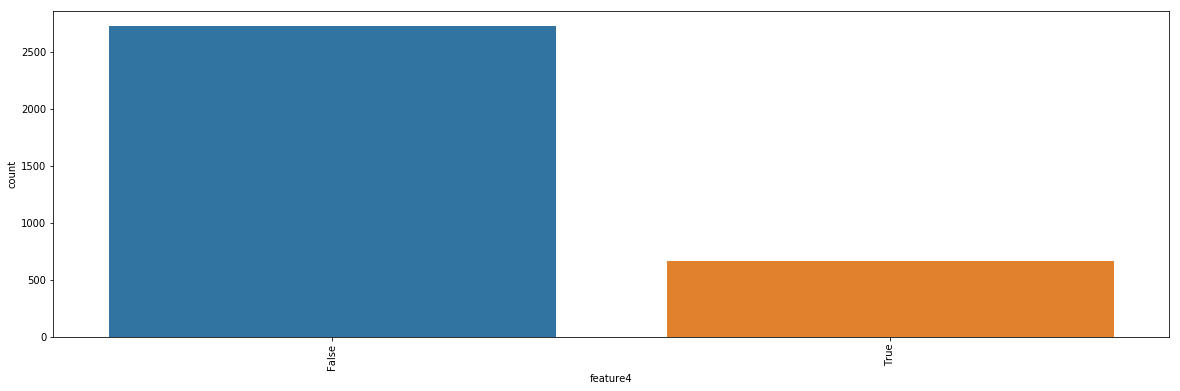

In [0]:
sns.countplot(train_data_og.feature4, order = train_data_og.feature4.value_counts().index )
plt.xticks(rotation = 90)
plt.show()

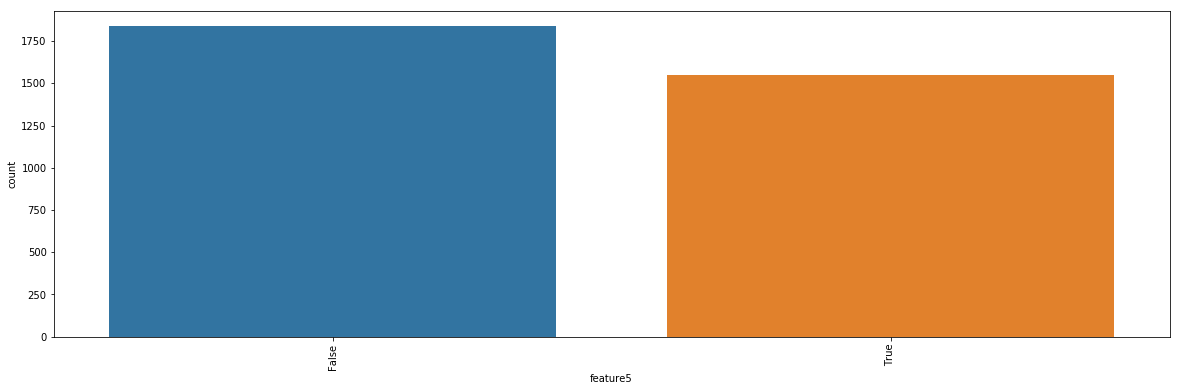

In [0]:
sns.countplot(train_data_og.feature5, order = train_data_og.feature5.value_counts().index )
plt.xticks(rotation = 90)
plt.show()

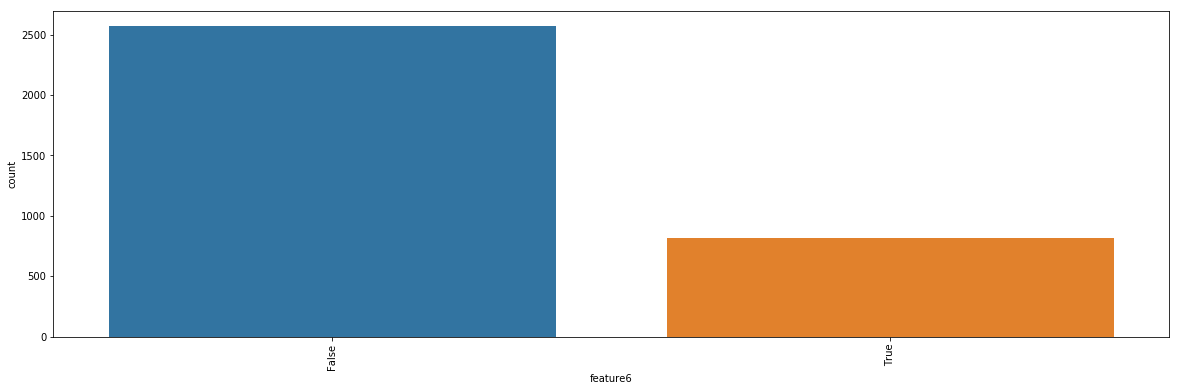

In [0]:
sns.countplot(train_data_og.feature6, order = train_data_og.feature6.value_counts().index )
plt.xticks(rotation = 90)
plt.show()

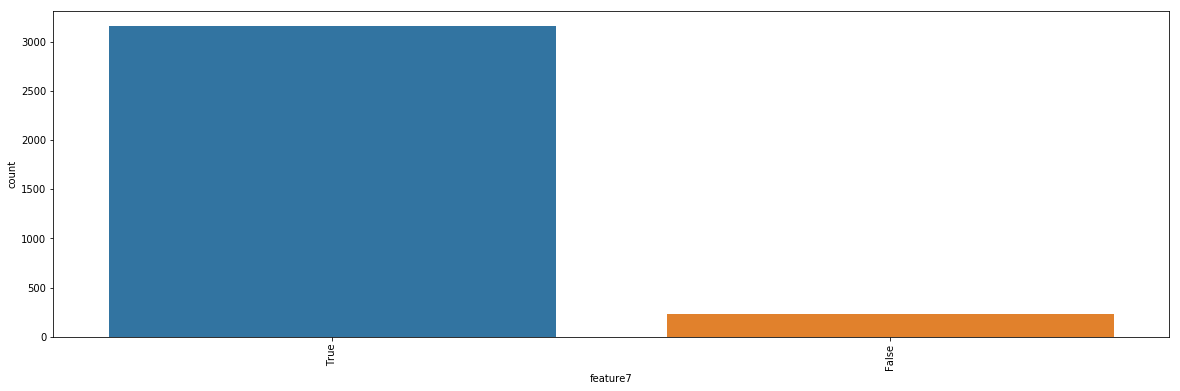

In [0]:
sns.countplot(train_data_og.feature7, order = train_data_og.feature7.value_counts().index )
plt.xticks(rotation = 90)
plt.show()

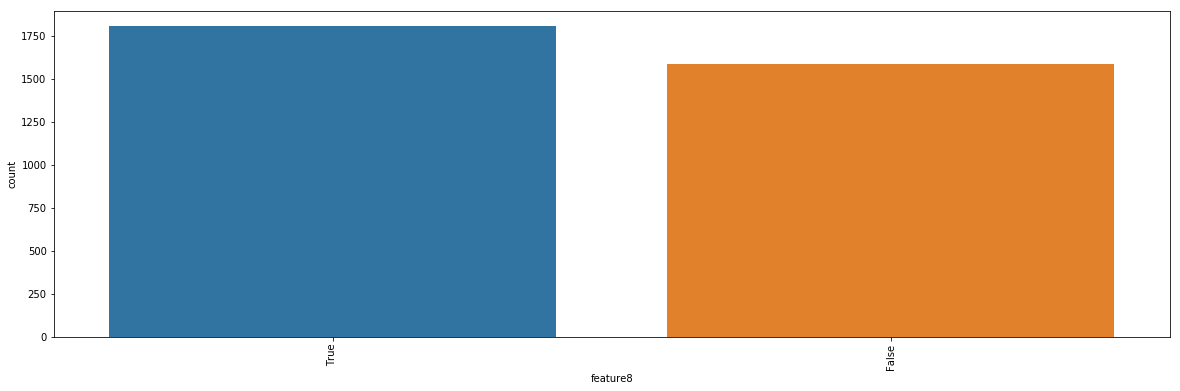

In [0]:
sns.countplot(train_data_og.feature8, order = train_data_og.feature8.value_counts().index )
plt.xticks(rotation = 90)
plt.show()

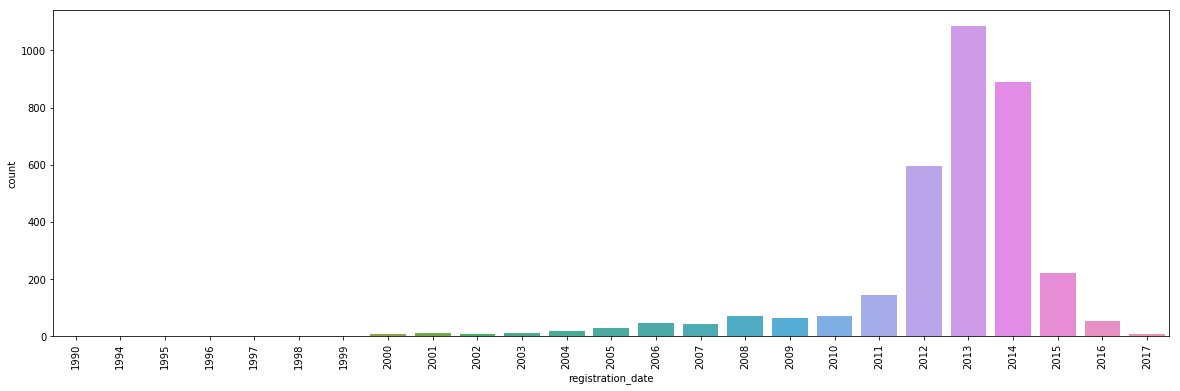

In [0]:
sns.countplot(train_data_og.registration_date.dt.year )
plt.xticks(rotation = 90)
plt.show()

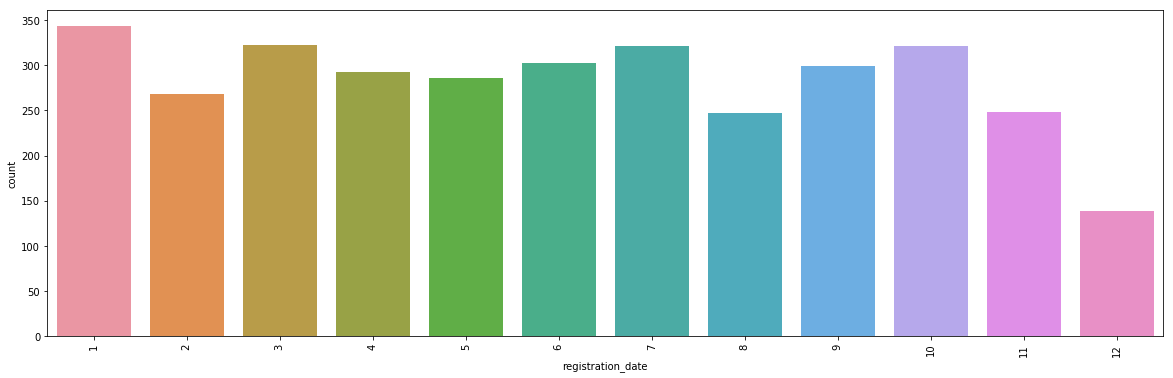

In [0]:
sns.countplot(train_data_og.registration_date.dt.month )
plt.xticks(rotation = 90)
plt.show()

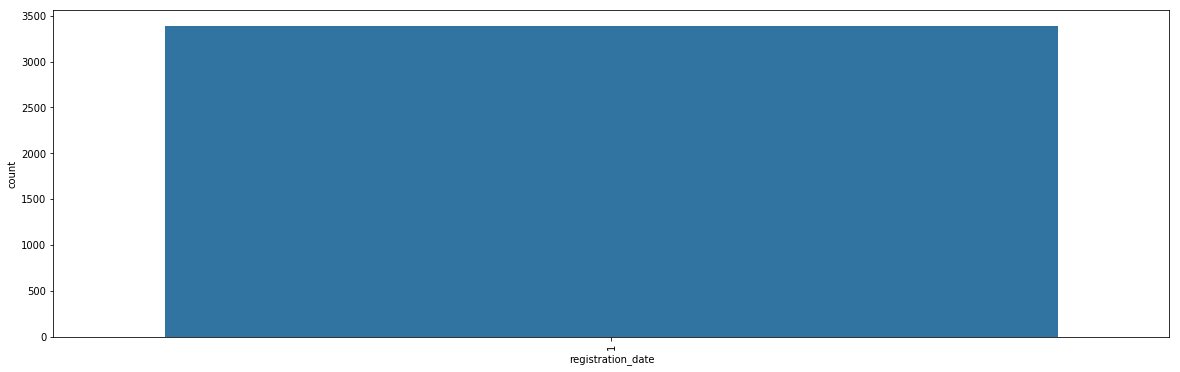

In [0]:
sns.countplot(train_data_og.registration_date.dt.day )
plt.xticks(rotation = 90)
plt.show()

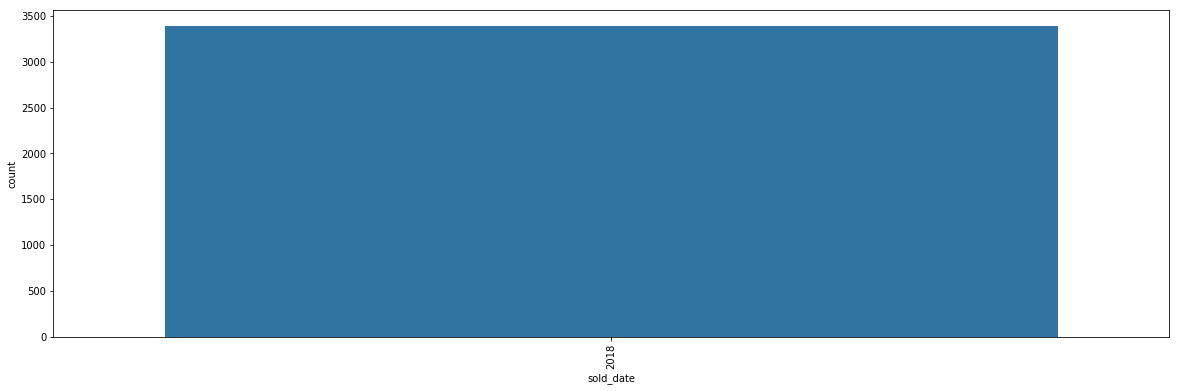

In [0]:
sns.countplot(train_data_og.sold_date.dt.year )
plt.xticks(rotation = 90)
plt.show()

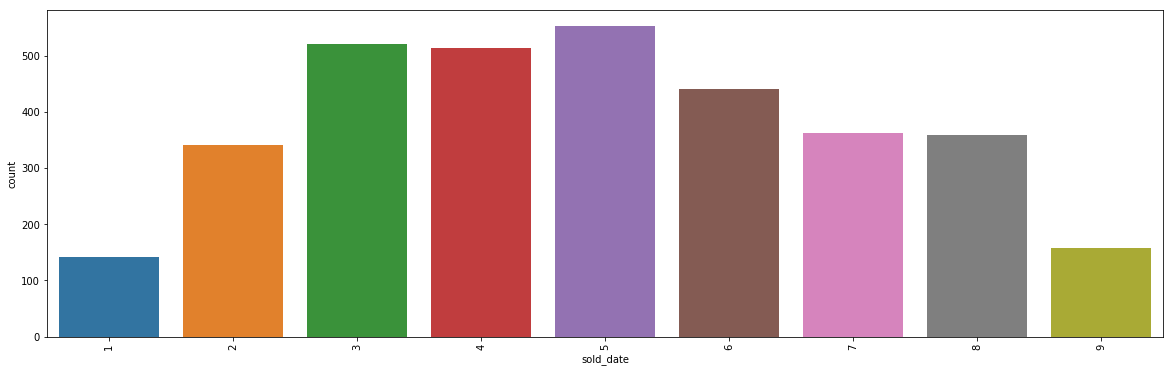

In [0]:
sns.countplot(train_data_og.sold_date.dt.month )
plt.xticks(rotation = 90)
plt.show()

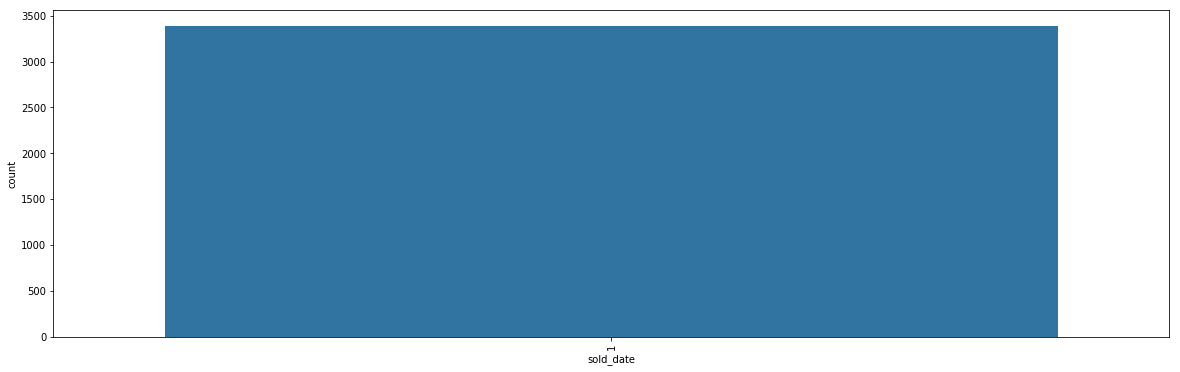

In [0]:
sns.countplot(train_data_og.sold_date.dt.day )
plt.xticks(rotation = 90)
plt.show()

### Bivariate

Comparision, corelation

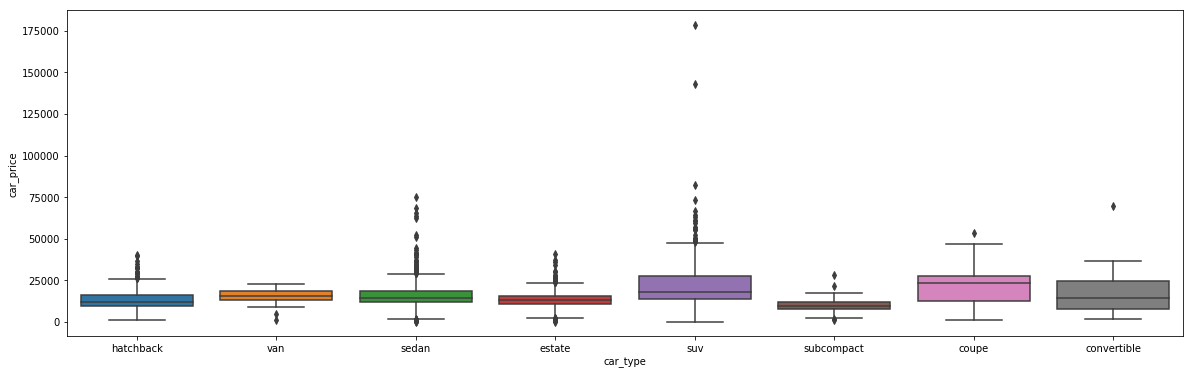

In [0]:
sns.boxplot(train_data.car_type, train_data.car_price)
plt.show()

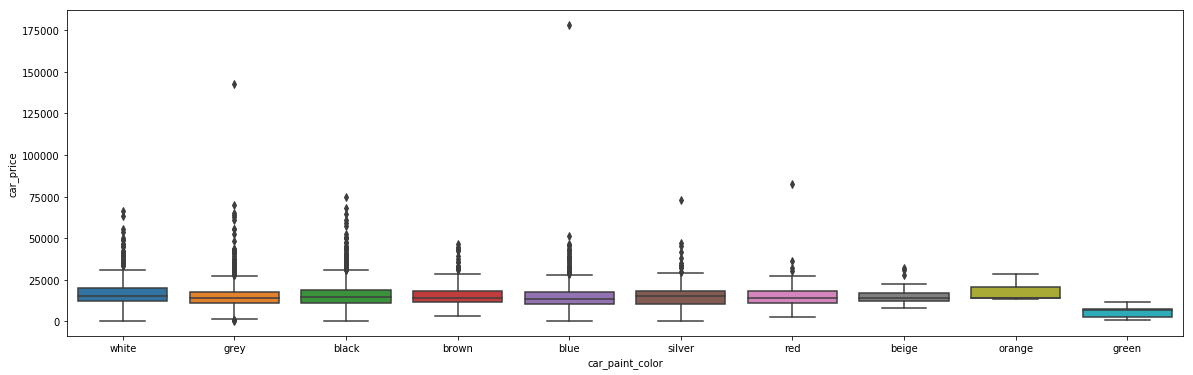

In [0]:
sns.boxplot(train_data.car_paint_color, train_data.car_price)
plt.show()

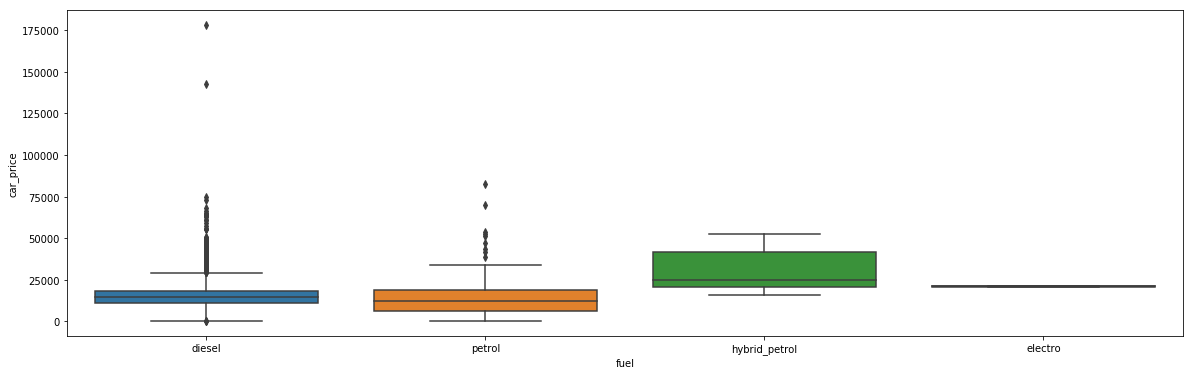

In [0]:
sns.boxplot(train_data.fuel, train_data.car_price)
plt.show()

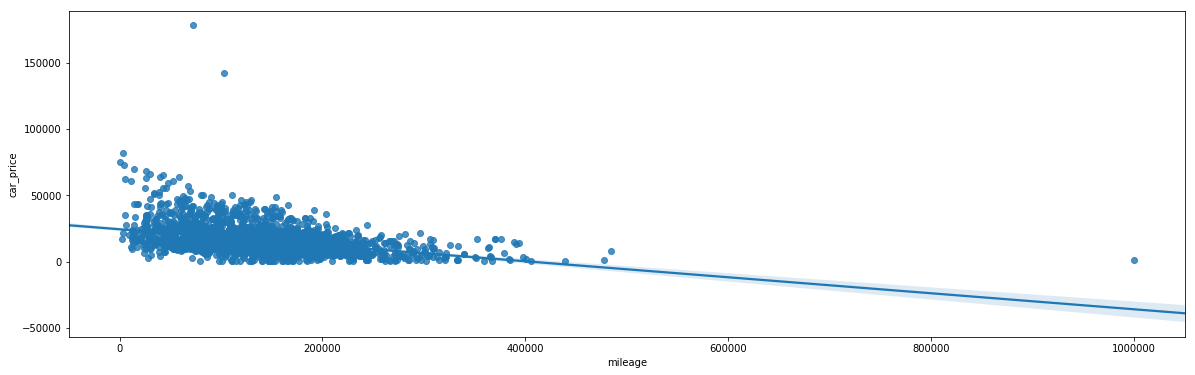

In [0]:
sns.regplot(train_data.mileage, train_data.car_price)
plt.show()

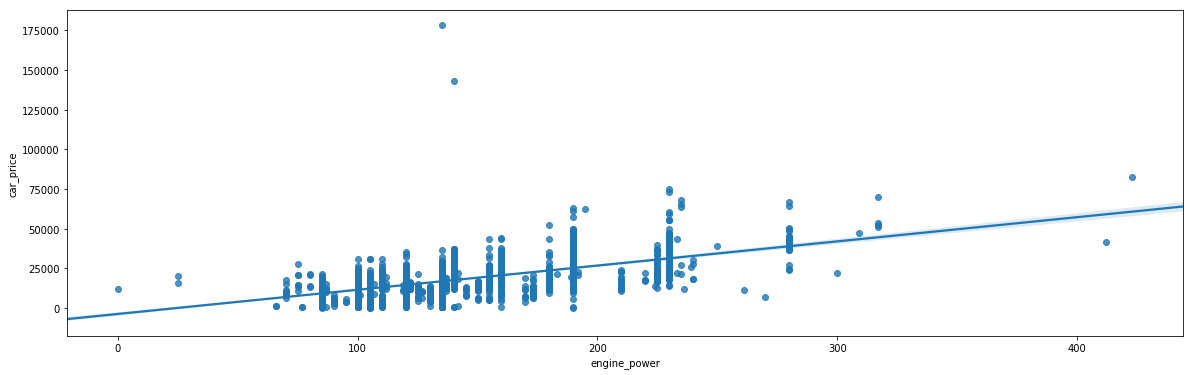

In [0]:
sns.regplot(train_data.engine_power, train_data.car_price)
plt.show()

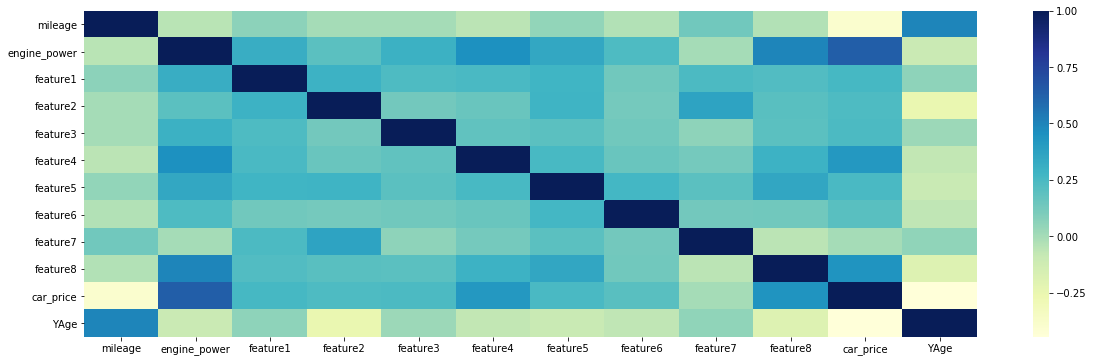

In [0]:
sns.heatmap(train_data.corr(), cmap="YlGnBu")

## Data Validation

Replace xxx with proper data  

1) Random split
2) Catogorical split
3) Time based split

In [0]:
# car_type and car_model
X = train_data.drop(['car_price'], axis = 1)
y = np.log(train_data["car_price"])

#cat_train, cat_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size = 0.75, stratify = train_data["car_type"], random_state = 42)

X_long = pd.get_dummies(X) #, dummy_na = True
#X_sub = pd.get_dummies(sub_data)

X_train, X_test, y_train, y_test = train_test_split(X_long, y, test_size = 0.25, train_size = 0.75, stratify = train_data["car_type"], random_state = 42)

In [0]:
print("Train set rows %s, cols %s and y is %s" % (X_train.shape[0], X_train.shape[1], y_train.shape[0]))
print("Test set rows %s, cols %s and y is %s" % (X_test.shape[0], X_test.shape[1], y_test.shape[0]))

Train set rows 2542, cols 128 and y is 2542
Test set rows 848, cols 128 and y is 848


In [0]:
# # Run only if required

# for x in set(X_train.columns) - set(X_sub.columns) :
#     X_sub[x] = 0

# X_sub = X_sub[X.columns]
    
# print("Submission set rows %s, cols %s and y is to be predicted" % (X_sub.shape[0], X_sub.shape[1]))

## Modeling

For Classification verify confusion matrix.  
Use 10 fold cross validation to verify final model.  

### Submission Part

Ensure that model is trained on whole set

### XGBoost

Monitor metric performance on both train and test.  

In [0]:
xgb_model = xgb.XGBRegressor(learning_rate=0.01, n_estimators = 100000)
xgb_model.fit(X_train, y_train, eval_metric = "rmse", eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 1000, early_stopping_rounds=10)

#joblib.dump(xgb_model, "drive/My Drive/PyColab Work/xxx/xgb_model.sav")
#confusion_matrix(y_train, xgb_model.predict(X_train))

[0]	validation_0-rmse:8.94132	validation_1-rmse:8.95559
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[1000]	validation_0-rmse:0.267837	validation_1-rmse:0.354683
Stopping. Best iteration:
[1828]	validation_0-rmse:0.25478	validation_1-rmse:0.350794



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=100000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

In [0]:
1 - np.sqrt(mean_squared_error(y_train, xgb_model.predict(X_train)))

0.7452197535811738

In [0]:
1 - np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test)))

0.6492056582031764

In [0]:
cvxgb_model = xgb.XGBRegressor(learning_rate=0.01, n_estimators = 1850)
cross_val_score(cvxgb_model, X_long, y, cv = 10)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/x

array([0.75227897, 0.69314778, 0.6659514 , 0.64560289, 0.62521047,
       0.82626623, 0.77591957, 0.86669233, 0.82692356, 0.74063575])

In [0]:
np.mean(np.array([0.75227897, 0.69314778, 0.6659514 , 0.64560289, 0.62521047,
       0.82626623, 0.77591957, 0.86669233, 0.82692356, 0.74063575]))

0.741862895

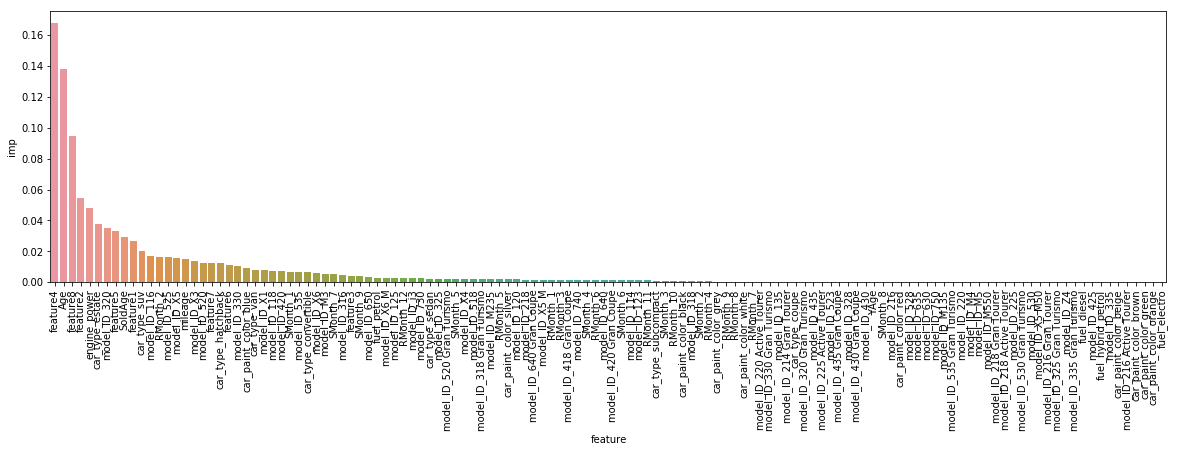

In [0]:
plt.figure(figsize = (20, 5))
sns.barplot("feature", "imp", data = pd.DataFrame( {'feature' : X_train.columns, 'imp' : xgb_model.feature_importances_ }).sort_values("imp", ascending = False) )
plt.xticks(rotation = 90)
plt.show()

#### SHAP

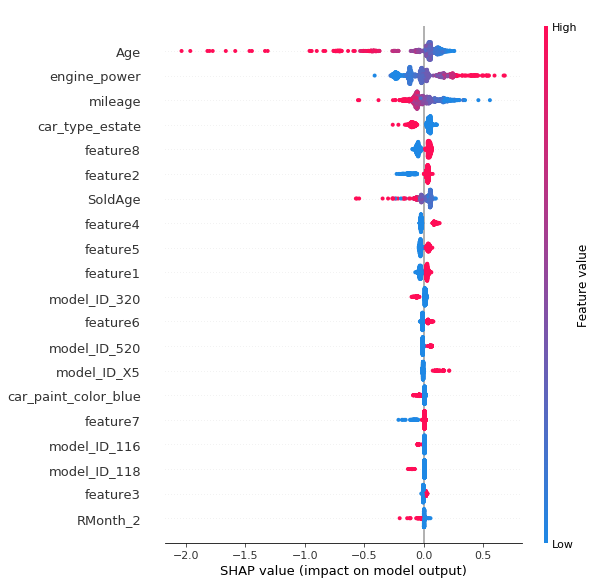

In [0]:
explainer = shap.TreeExplainer(xgb_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

In [0]:
shap_values = explainer.shap_values(X_test.iloc[0:nsize,:])
b = shap.summary_plot(shap_values, X_test.iloc[0:nsize,:])

#### Hyperparameter Tuning

Draw appropriate graph to understand impact of two hyperparameters.  
eg: rounds to maxdepth can give an idea where it overfits.

##### GridSearchCV

In [0]:
cv= RepeatedKFold(2, 2)
xgb_engine = xgb.XGBRegressor() #n_estimator not used
xgb_params = {'booster' : ['gbtree'],
              'max_depth' : [3, 4], 
              'gamma' : [0], 
              'learning_rate' : [0.3], 
              "n_estimators" : [100000], 
              'min_child_weight' : [5, 10], 
              'subsample' : [1], 
              'colsample_bytree' : [0.7, 1], 
              'colsample_bylevel' : [1], 
              'colsample_bynode' : [1], 
              'reg_lambda' : [0], 
              'reg_alpha' : [0]}

xgb_grid = GridSearchCV(xgb_engine, xgb_params, cv = cv, n_jobs = 4, verbose = 0, return_train_score  = True)
xgb_grid.fit(X_train, y_train, eval_set = [(X_train, y_train)], early_stopping_rounds=10, verbose = 1000)

#joblib.dump(xgb_grid, "F:/Vasim/Python Stuff/Flight/gridxgboost.sav")

#print( np.sqrt( -cross_val_score(xgb_grid.best_estimator_, X_train, y_train, cv = cv, scoring = "neg_mean_squared_error") ) )
#print( np.sqrt( mean_squared_error(y_test, xgb_grid.predict(X_test)) ) )

##### Skopt

In [0]:
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

# set up hyperparameter space
space = [Integer(3, 50, name='max_depth'),
         Integer(8, 200, name='n_estimators'),
         Integer(3, 50, name='min_child_weight'),
         Real(0.001, 1.0, name='learning_rate')]

regressor = xgb.XGBRegressor()

from sklearn.model_selection import cross_val_score

@use_named_args(space)
def objective(**params):
    regressor.set_params(**params)
    return -np.mean(cross_val_score(regressor, X_train, y_train, cv=5, n_jobs=1, scoring='neg_mean_squared_error'))

In [0]:
reg_gp = gp_minimize(objective, space, verbose=False)

print('best score: {}'.format(reg_gp.fun))

print('best params:')
print('        max_depth: {}'.format(reg_gp.x[0]))
print('     n_estimators: {}'.format(reg_gp.x[1]))
print(' min_child_weight: {}'.format(reg_gp.x[2]))
print('    learning_rate: {}'.format(reg_gp.x[3]))

In [0]:
import skopt.plots
skopt.plots.plot_convergence(reg_gp)

In [0]:
skopt.plots.plot_evaluations(reg_gp, bins = 20)
plt.show()

In [0]:
skopt.plots.plot_objective(reg_gp)
plt.show()

##### Hyperopt

### LightGBM
Inbuilt Categorical features

In [0]:
lgbm_model = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=100000)
lgbm_model.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=100, verbose = 1000)

#### SHAP

In [0]:
explainer = shap.TreeExplainer(lgbm_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

#### Hyperparamter Tuning

In [0]:
lgbm_engine = lgb.LGBMRegressor()
lgbm_params = {'max_depth' : [17], 'learning_rate' : [0.05], 'n_estimators': [100000],  'min_child_samples' : [3], 'num_leaves' : [40], 'min_child_weight' : [0.001], 
               'min_split_gain' : [0], 'colsample_bytree' : [0.3], 'reg_alpha' : [0], 'reg_lamba' : [0], 'importance_type' : ['split'] }

lgbm_grid = GridSearchCV(lgbm_engine, lgbm_params, cv = 4, n_jobs = 4, verbose = 0)
lgbm_grid.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=100, verbose = 1000)
#print( np.sqrt( -cross_val_score(lgbm_grid.best_estimator_, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error") ) )
#print( np.sqrt( mean_squared_error(y_test, lgbm_grid.predict(X_test)) ) )

### CatBoost

Inbuilt Categorical features  

The cat.cv - inbuilt cross validation gives cross validated result on each iterations.   
The only hyperparameter we can select from in built cv is no of iteration.  
Try sklearn cv type with for loop for cv score or skopt or hyperopt module.  

In [0]:
from catboost import CatBoostRegressor, Pool
categorical_features_indices = np.where(cat_train.dtypes == 'object')[0]

cat_model = CatBoostRegressor(iterations = 100000, learning_rate = 0.01)
cat_model.fit(cat_train, y_train, eval_set = (cat_test, y_test), cat_features = categorical_features_indices, plot = True, verbose = 1000, early_stopping_rounds=100)

#print( np.sqrt( -cross_val_score(cat_model, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error", verbose = False) ) )
#np.sqrt(mean_squared_error(y_test, cat_model.predict(X_test)))

#### SHAP

In [0]:
explainer = shap.TreeExplainer(cat_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

#### Hyperparamter Tuning

In [0]:
cat_engine = CatBoostRegressor()
cat_params = {'max_depth' : [4], 'learning_rate' : [0.1], 'iterations': [100000], 'colsample_bylevel' : [1]}
    
cat_grid = GridSearchCV(cat_engine, cat_params, cv = 4, n_jobs = 4, verbose = False)
cat_grid.fit(cat_train, y_train, eval_set = (cat_val, y_val), cat_features = categorical_features_indices, plot = True, verbose = 1000, early_stopping_rounds=100)

### SVM

Apply scaling

In [0]:
#%%script false

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Scaling only on numeric data.
svmpipe = Pipeline([ ( "std", StandardScaler() ), ("mimax", MinMaxScaler()) , ( "svm", SVR(gamma = 'scale', kernel = 'rbf', C = 1.5, epsilon = 0.1, max_iter=-1) ) ])
svmpipe.fit(X_train, y_train)

#np.sqrt( -cross_val_score(svmpipe, X_train.astype(float), y_train.astype(float), cv = 5, scoring = "neg_mean_squared_error") )
np.sqrt( mean_squared_error(y_test, svmpipe.predict(X_test))) 

#### SHAP

#### Hyperparamter Tuning

### KNN

Apply scaling

In [0]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

#Scaling on numeric data only
neigh = KNeighborsRegressor(n_neighbors=5)
knnpipe = Pipeline([ ( "std", StandardScaler() ), ("minmax", MinMaxScaler() ), ( "knn", neigh ) ])

#scale data
knnpipe.fit(X_train, y_train) 
print( np.sqrt( -cross_val_score(neigh, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error") ) )
#np.sqrt(mean_squared_error(y_test, neigh.predict(X_test)))

#### SHAP

#### Hyperparamter Tuning

### Keras

Apply scaling

In [0]:
#!pip install tensorboardcolab
# Apply scaling

from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout
#tbc=TensorBoardColab()

model2 = Sequential()
model2.add(Dense(200, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model2.add(Dense(30, kernel_initializer='normal', activation='relu'))
model2.add(Dropout(.10))
#model.add(Dense(10, kernel_initializer='normal', activation='relu'))
#model.add(Dropout(.10))
model2.add(Dense(1, kernel_initializer='normal'))

model2.compile(loss='mean_squared_error', optimizer='adam')

model2.fit(X_train, y_train, epochs = 18, verbose = 0) #callbacks=[TensorBoardColabCallback(tbc)]
pd.DataFrame( {"Actual" : np.exp(y_test), "Predict" : np.exp(model2.predict(X_test)[0:,0])} ).describe()

#### SHAP

#### Hyperparamter Tuning

### Linear

inludes - Logistic  
Panelty - Ridge, Lasso and ElasticNet  


#### SHAP

#### Hyperparamter Tuning

## Stacking

In [0]:
#mlextend